## Hyperparameter tuning via Optuna for Binary MLP model

### Being a binary model this notebook will be limited to predicting one class 1 or 0, yes or no.
### Here I will be predicting if a cell received a treatment or not

In [1]:
import sys
import torch
import optuna
import plotly

import pandas as pd
from pathlib import Path
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve


sys.path.append("..")
from utils.utils import df_stats
from MLP_utils.utils import data_split
from MLP_utils.utils import Dataset_formatter

# from MLP_utils.utils import build_model_custom
# from MLP_utils.utils import train_n_validate
from MLP_utils.utils import objective
from MLP_utils.utils import extract_best_trial_params
from MLP_utils.utils import optimized_model
from MLP_utils.utils import train_optimized_model
from MLP_utils.utils import plot_metric_vs_epoch
from MLP_utils.utils import test_optimized_model
from MLP_utils.utils import un_nest
from MLP_utils.utils import results_output
from MLP_utils.parameters import Parameters

params = Parameters()

In [2]:
# Import Data
# set data file path under pathlib path for multi-system use
file_path = Path(
    "../../Extracted_Features_(CSV_files)/interstellar_wave3_sc_norm_fs_cellprofiler.csv.gz"
)
df = pd.read_csv(
    file_path,
    low_memory=False,
)

Combine treatment with dosage to be able to discern treatments with different doses as a different condition

In [3]:
# Combine treatment and dose
df["Metadata_treatment"] = df["Metadata_treatment"] + "_" + df["Metadata_dose"]
print(df["Metadata_treatment"].unique())

# Generate df speceific to analysis and model
df = df.query(
    "Metadata_treatment == 'LPS_10µg/ml'| Metadata_treatment == 'Media only_0'"
)
print(df["Metadata_treatment"].unique())

df_stats(df)
# Drop na and reindex accordingly
df = df.dropna()
df.reindex()
# Check for Nans again
df_stats(df)
# Understand categorical data such as treatment and dosing
df[["Metadata_treatment", "Metadata_dose"]].drop_duplicates()
if params.SUBSET_OPTION:
    df = df.sample(n=params.SUBSET_NUMBER)
else:
    pass
# Code snipptet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

['LPS_10µg/ml' 'Disulfiram_2.5µM' 'LPS_1µg/ml' 'Disulfiram_0.1µM'
 'H2O2_500µM' 'Thapsi_10µM' 'H2O2_50µM' 'Thapsi_1µM' 'ATP_1mM'
 'LPS + Nigericin_1µg/ml + 10µM' 'ATP_0.1mM'
 'LPS + Nigericin_1µg/ml + 1µM' 'Flagellin_1µg/ml' 'DMSO 0.1%_0'
 'Flagellin_0.1µg/ml' 'Media only_0']
['LPS_10µg/ml' 'Media only_0']
The dimensions of the data are: (36718, 568)
Number of total missing values across all columns: 470
The dimensions of the data are: (36589, 568)
Number of total missing values across all columns: 0


### Setting up data for network training

In [4]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["Metadata_treatment"] = le.fit_transform(df_descriptive["Metadata_treatment"])
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop("Metadata_treatment", axis=1)
df_values_Y = df_values["Metadata_treatment"]

X_train, X_test, X_val, Y_train, Y_test, Y_val = data_split(
    df_values_X, df_values_Y, 0.8, 0.1, 0.1
)

In [5]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

IN_FEATURES = X_train.shape[1]
print("Number of in features: ", IN_FEATURES)
out_features = len(df_values["Metadata_treatment"].unique())
print("Number of out features: ", out_features)

Number of in features:  555
Number of out features:  2


In [6]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=params.BATCH_SIZE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=params.BATCH_SIZE
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=params.BATCH_SIZE
)

In [7]:
# wrap the objective function inside of a lambda function to pass args...
objective_lambda_func = lambda trial: objective(
    trial, IN_FEATURES, train_loader, valid_loader, params, False
)
# Study is the object for model optimzation
study = optuna.create_study(direction="minimize")
# Here I appply the optimize function of the study to the objective function
# This optimizes each parameter specified to be optinmized from the defined search space
study.optimize(objective_lambda_func, n_trials=params.N_TRIALS)
# Prints out the best trial's optimized parameters
objective(study.best_trial, IN_FEATURES, train_loader, valid_loader, params, True)

[I 2023-03-21 09:01:33,925] A new study created in memory with name: no-name-e90502dd-6e5d-4551-b85d-0e40b9b39091
[I 2023-03-21 09:01:45,675] Trial 0 finished with value: 0.6892657950520515 and parameters: {'n_layers': 8, 'n_units_l0': 17, 'dropout_0': 0.30000000000000004, 'n_units_l1': 30, 'dropout_1': 0.4, 'n_units_l2': 39, 'dropout_2': 0.5, 'n_units_l3': 17, 'dropout_3': 0.35, 'n_units_l4': 26, 'dropout_4': 0.5, 'n_units_l5': 13, 'dropout_5': 0.45000000000000007, 'n_units_l6': 19, 'dropout_6': 0.25, 'n_units_l7': 40, 'dropout_7': 0.4, 'learning_rate': 0.08027529880489309, 'optimizer': 'Adam', 'n_unit': 5}. Best is trial 0 with value: 0.6892657950520515.
[I 2023-03-21 09:01:49,234] Trial 1 finished with value: 0.6821914267539978 and parameters: {'n_layers': 3, 'n_units_l0': 10, 'dropout_0': 0.25, 'n_units_l1': 28, 'dropout_1': 0.30000000000000004, 'n_units_l2': 48, 'dropout_2': 0.25, 'learning_rate': 0.0920488296347597, 'optimizer': 'Adam', 'n_unit': 31}. Best is trial 1 with value: 

Validation Accuracy: 69.99333333333334
Validation Loss: 0.5519463157653809
Training Accuracy: 77.73166666666665
Training Loss: 0.4729521331439415


In [8]:
optuna.visualization.plot_optimization_history(study)

In [9]:
optuna.visualization.plot_intermediate_values(study)

In [10]:
# call function
param_dict = extract_best_trial_params(study.best_params)

In [11]:
# call the optimized trainig model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    params.TRAIN_EPOCHS, train_loader, valid_loader, IN_FEATURES, param_dict, params
)

Epoch 0: Validation loss decreased (inf --> 0.641619).  Saving model ...
	 Train_Loss: 0.6832 Train_Acc: 54.333 Val_Loss: 0.6416  BEST VAL Loss: 0.6416  Val_Acc: 67.333

Epoch 1: Validation loss decreased (0.641619 --> 0.629985).  Saving model ...
	 Train_Loss: 0.6613 Train_Acc: 64.167 Val_Loss: 0.6300  BEST VAL Loss: 0.6300  Val_Acc: 66.667

Epoch 2: Validation loss decreased (0.629985 --> 0.619962).  Saving model ...
	 Train_Loss: 0.6450 Train_Acc: 68.417 Val_Loss: 0.6200  BEST VAL Loss: 0.6200  Val_Acc: 68.000

Epoch 3: Validation loss decreased (0.619962 --> 0.612053).  Saving model ...
	 Train_Loss: 0.6315 Train_Acc: 69.917 Val_Loss: 0.6121  BEST VAL Loss: 0.6121  Val_Acc: 69.333

Epoch 4: Validation loss decreased (0.612053 --> 0.605828).  Saving model ...
	 Train_Loss: 0.6222 Train_Acc: 70.667 Val_Loss: 0.6058  BEST VAL Loss: 0.6058  Val_Acc: 68.667

Epoch 5: Validation loss decreased (0.605828 --> 0.600703).  Saving model ...
	 Train_Loss: 0.6132 Train_Acc: 71.833 Val_Loss: 0.6

In [12]:
training_stats = pd.DataFrame(
    zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
    columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
)

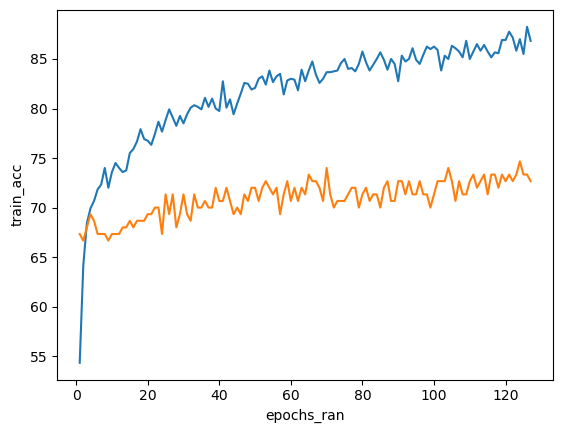

In [13]:
plot_metric_vs_epoch(training_stats, "epochs_ran", "train_acc", "valid_acc")

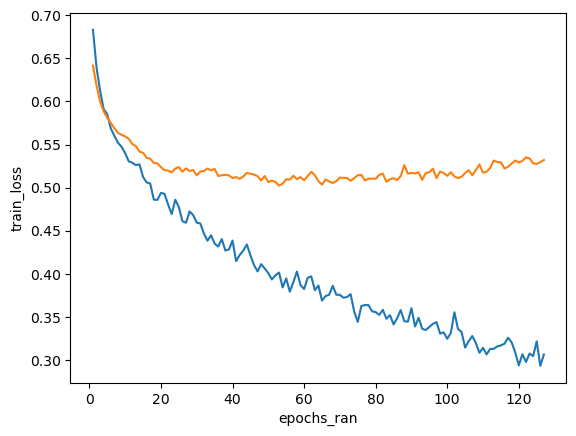

In [14]:
plot_metric_vs_epoch(training_stats, "epochs_ran", "train_loss", "valid_loss")

In [15]:
# calling the testing function and outputing list values of tested model
y_pred_list, y_pred_prob_list = test_optimized_model(
    model, test_loader, IN_FEATURES, param_dict, params
)


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

              precision    recall  f1-score   support

           0       0.51      0.64      0.57        69
           1       0.61      0.48      0.54        81

    accuracy                           0.55       150
   macro avg       0.56      0.56      0.55       150
weighted avg       0.56      0.55      0.55       150



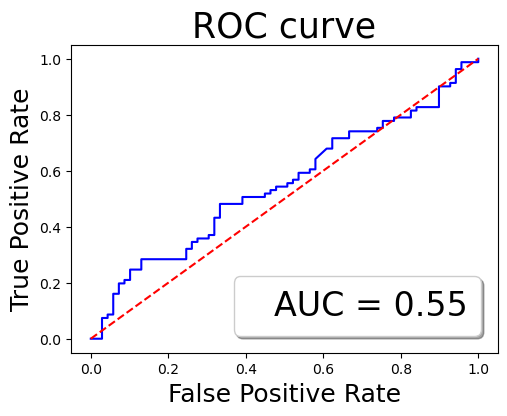

In [16]:
# Call visualization function
results_output(y_pred_list, y_pred_prob_list, Y_test)